# OPERA Surface Displacement from Sentinel-1: Access and Visualize

Authors: Harshini Girish (UAH), Rajat Shinde (UAH), Alex Mandel (Development Seed), Chuck Daniels (Development Seed), Julia Signell (Element84)

Date:July 28, 2025

Description: This tutorial aims to provide information and code to help users get started working with the OPERA Sentinel-1 Surface Displacement product using the MAAP. We will search for the data within NASA’s Common Metadata Repository (CMR).

## Run This Notebook

To access and run this tutorial within MAAP’s Algorithm Development Environment (ADE), please refer to the “Getting started with the MAAP” section of our documentation.

Disclaimer: It is highly recommended that you run this tutorial within MAAP’s ADE, which already includes packages specific to MAAP, such as maap-py. Running the tutorial outside of the MAAP ADE may lead to errors.



## About the Data

> The Level-3 OPERA Sentinel-1 Surface Displacement (DISP) product is generated through interferometric time-series analysis of Level-2 Coregistered Sentinel-1 Single Look Complex (CSLC) datasets. Using a hybrid Persistent Scatterer (PS) and Distributed Scatterer (DS) approach, this product quantifies Earth's surface displacement in the radar line-of-sight. The DISP products enable the detection of anthropogenic and natural surface changes, including subsidence, tectonic deformation, and landslides. 

> The OPERA DISP suite comprises complementary datasets derived from Sentinel-1 and NISAR inputs, designated as DISP-S1 and DISP-NI, respectively. Each product, created per acquisition, adheres to a consistent structure, HDF5 file format, file-naming convention, and a 30 m spatial posting. This collection specifically includes DISP-S1 products, derived from Sentinel-1 data. For visualization and quick exploration, the Pangeo Image can be used for these datasets. 


Source: [OPERA Surface Displacement from Sentinel-1](https://cmr.earthdata.nasa.gov/search/concepts/C3294057315-ASF.html)

## Importing Packages

In [7]:
!pip install dask

  Using cached dask-2025.7.0-py3-none-any.whl.metadata (3.8 kB)
  Using cached cloudpickle-3.1.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached partd-1.4.2-py3-none-any.whl.metadata (4.6 kB)
  Using cached toolz-1.0.0-py3-none-any.whl.metadata (5.1 kB)
  Using cached locket-1.0.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached dask-2025.7.0-py3-none-any.whl (1.5 MB)
Using cached cloudpickle-3.1.1-py3-none-any.whl (20 kB)
Using cached partd-1.4.2-py3-none-any.whl (18 kB)
Using cached toolz-1.0.0-py3-none-any.whl (56 kB)
Using cached locket-1.0.0-py2.py3-none-any.whl (4.4 kB)


In [5]:
!pip install earthaccess
!pip install maap


  Using cached earthaccess-0.14.0-py3-none-any.whl.metadata (8.2 kB)
  Using cached multimethod-2.0-py3-none-any.whl.metadata (9.2 kB)
  Using cached pqdm-0.2.0-py2.py3-none-any.whl.metadata (3.2 kB)
  Using cached python_cmr-0.13.0-py3-none-any.whl.metadata (10 kB)
  Using cached tinynetrc-1.3.1-py2.py3-none-any.whl.metadata (2.9 kB)
  Using cached bounded_pool_executor-0.0.3-py3-none-any.whl.metadata (2.7 kB)
Using cached earthaccess-0.14.0-py3-none-any.whl (64 kB)
Using cached multimethod-2.0-py3-none-any.whl (9.8 kB)
Using cached pqdm-0.2.0-py2.py3-none-any.whl (6.8 kB)
Using cached python_cmr-0.13.0-py3-none-any.whl (14 kB)
Using cached tinynetrc-1.3.1-py2.py3-none-any.whl (3.9 kB)
Using cached bounded_pool_executor-0.0.3-py3-none-any.whl (3.4 kB)
  Using cached MAAP-0.2.1-py3-none-any.whl.metadata (2.4 kB)
  Using cached numpy-1.20.3.zip (7.8 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
ERROR: Exception:
Traceback (most recent call l

In [1]:
# --- MAAP & Cloud Access ---
from maap.maap import MAAP
import earthaccess
from s3fs import S3FileSystem

# File Access & Processing -
import os
import fsspec
import h5py
import re
import numpy as np
import xarray as xr
import dask

# Plotting & Visualization 
import matplotlib.pyplot as plt
import folium

#  Geospatial 
import geopandas as gpd
from shapely.geometry import box, Polygon

# Misc
import requests
from pprint import pprint

# Initialize MAAP
maap = MAAP()


## Searching the Data

This performs a granule search using the `maap.searchGranule()` function on the OPERA Sentinel-1 displacement product collection.

In [2]:
collection = maap.searchCollection(
    cmr_host="cmr.earthdata.nasa.gov",
    short_name="OPERA_L3_DISP-S1_V1"
)
len(collection)



1

In [3]:
results = maap.searchGranule(
    short_name="OPERA_L3_DISP-S1_V1",
    cmr_host="cmr.earthdata.nasa.gov",
    limit=100
)

records = []
for r in results:
    granule = r["Granule"]
    try:
        points = granule["Spatial"]["HorizontalSpatialDomain"]["Geometry"]["GPolygon"]["Boundary"]["Point"]
        coords = [(float(p["PointLongitude"]), float(p["PointLatitude"])) for p in points]
        if len(coords) >= 3:
            polygon = Polygon(coords)
            records.append({
                "GranuleUR": granule["GranuleUR"],
                "geometry": polygon
            })
    except KeyError:
        continue
if records:
    gdf = gpd.GeoDataFrame(records, crs="EPSG:4326")
    print(f"Found {len(gdf)} granules with polygons.")

    

Found 100 granules with polygons.


## Visualizing with Bounding Boxes

This code creates an interactive map showing bounding boxes for each granule using `folium`. It extracts geometry bounds from a `GeoDataFrame`, constructs a new `GeoDataFrame` of bounding boxes, and overlays them on a Leaflet map with tooltips displaying each granule's ID.


In [4]:
bounding_boxes = []
granule_ids = []

for i, geom in enumerate(gdf.geometry):
    minx, miny, maxx, maxy = geom.bounds
    bounding_boxes.append(box(minx, miny, maxx, maxy))  
    granule_ids.append(gdf["GranuleUR"][i])


bbox_gdf = gpd.GeoDataFrame({
    "GranuleUR": granule_ids,
    "geometry": bounding_boxes
}, crs="EPSG:4326")


map_center = bbox_gdf.geometry.union_all().centroid
m = folium.Map(location=[map_center.y, map_center.x], zoom_start=6)


for _, row in bbox_gdf.iterrows():
    folium.GeoJson(
        row["geometry"],
        style_function=lambda x: {
            "color": "green",
            "weight": 2,
            "fillOpacity": 0.1
        },
        tooltip=row["GranuleUR"]
    ).add_to(m)

m


## Search Granules using filters

### Temporal Filter

Now that we have our collection ID, let’s search for granules within the collection. We’ll also add a temporal filter to our search. If you would like to search for granules without the temporal filter, simply comment out or remove the `temporal=date_range` line.

In [5]:
date_range = "2016-07-01T00:00:00Z,2016-07-25T23:59:59Z"
concept_id = collection[0]["concept-id"]

results = maap.searchGranule(
    temporal=date_range,
    concept_id=concept_id,
    cmr_host="cmr.earthdata.nasa.gov"
)

print(f"Found {len(results)} granules")
for r in results:
    print(r["Granule"]["GranuleUR"])


Found 20 granules
OPERA_L3_DISP-S1_IW_F40286_VV_20160701T005555Z_20160818T005558Z_v1.0_20250724T212204Z
OPERA_L3_DISP-S1_IW_F40286_VV_20160701T005555Z_20170322T005556Z_v1.0_20250724T212204Z
OPERA_L3_DISP-S1_IW_F40286_VV_20160701T005555Z_20160911T005559Z_v1.0_20250724T212204Z
OPERA_L3_DISP-S1_IW_F40286_VV_20160701T005555Z_20170226T005556Z_v1.0_20250724T212204Z
OPERA_L3_DISP-S1_IW_F40286_VV_20160701T005555Z_20171012T005606Z_v1.0_20250724T212204Z
OPERA_L3_DISP-S1_IW_F40286_VV_20160701T005555Z_20170509T005558Z_v1.0_20250724T212204Z
OPERA_L3_DISP-S1_IW_F40286_VV_20160701T005555Z_20160725T005557Z_v1.0_20250724T212204Z
OPERA_L3_DISP-S1_IW_F40286_VV_20160701T005555Z_20170403T005556Z_v1.0_20250724T212204Z
OPERA_L3_DISP-S1_IW_F40286_VV_20160701T005555Z_20170918T005605Z_v1.0_20250724T212204Z
OPERA_L3_DISP-S1_IW_F40286_VV_20160701T005555Z_20170602T005559Z_v1.0_20250724T212204Z
OPERA_L3_DISP-S1_IW_F40286_VV_20160701T005555Z_20171024T005606Z_v1.0_20250724T212204Z
OPERA_L3_DISP-S1_IW_F40286_VV_201607

### Spatial Filter

Another filter we can apply is a spatial filter.

In [20]:
granule_bbox = "-104.57446,23.91956,-101.85669,25.95518" 

results = maap.searchGranule(
    concept_id=concept_id,
    bounding_box=granule_bbox,
    cmr_host="cmr.earthdata.nasa.gov"
)

print(f"Found {len(results)} granules")
for r in results:
    print(r["Granule"]["GranuleUR"])


Found 20 granules
OPERA_L3_DISP-S1_IW_F40291_VV_20160701T005736Z_20161029T005740Z_v1.0_20250724T213304Z
OPERA_L3_DISP-S1_IW_F40291_VV_20160701T005736Z_20170310T005736Z_v1.0_20250724T213304Z
OPERA_L3_DISP-S1_IW_F40291_VV_20160701T005736Z_20161005T005740Z_v1.0_20250724T213304Z
OPERA_L3_DISP-S1_IW_F40291_VV_20160701T005736Z_20160725T005737Z_v1.0_20250724T213304Z
OPERA_L3_DISP-S1_IW_F40291_VV_20160701T005736Z_20170403T005737Z_v1.0_20250724T213304Z
OPERA_L3_DISP-S1_IW_F40291_VV_20160701T005736Z_20161216T005739Z_v1.0_20250724T213304Z
OPERA_L3_DISP-S1_IW_F40291_VV_20160701T005736Z_20170214T005736Z_v1.0_20250724T213304Z
OPERA_L3_DISP-S1_IW_F40291_VV_20160701T005736Z_20170322T005736Z_v1.0_20250724T213304Z
OPERA_L3_DISP-S1_IW_F40291_VV_20160701T005736Z_20161122T005739Z_v1.0_20250724T213304Z
OPERA_L3_DISP-S1_IW_F40291_VV_20160701T005736Z_20170226T005736Z_v1.0_20250724T213304Z
OPERA_L3_DISP-S1_IW_F40291_VV_20160701T005736Z_20160818T005738Z_v1.0_20250724T213304Z
OPERA_L3_DISP-S1_IW_F40291_VV_201607

## Locally download and Inspect 

This code snippet queries NASA’s CMR via the MAAP API to fetch a granule from the `OPERA_L3_DISP-S1_V1` collection and downloads it locally into a folder called `opera_data`. It then uses `xarray.open_dataset()` with the `h5netcdf` engine to open the local NetCDF file and inspects its structure, including its shape, coordinates, and variable metadata.


In [2]:
results = maap.searchGranule(
    short_name="OPERA_L3_DISP-S1_V1",
    cmr_host="cmr.earthdata.nasa.gov"
)


data_dir = "opera_data"
os.makedirs(data_dir, exist_ok=True)


file_path = results[0].getData(data_dir)

ds = xr.open_dataset(file_path, engine="h5netcdf")
print(ds)


<xarray.Dataset> Size: 4GB
Dimensions:                         (y: 7915, x: 9548, time: 1)
Coordinates:
  * y                               (y) float64 63kB 1.995e+06 ... 1.758e+06
  * x                               (x) float64 76kB 7.682e+04 ... 3.632e+05
  * time                            (time) datetime64[ns] 8B 2016-08-18T00:55...
Data variables: (12/13)
    spatial_ref                     int64 8B ...
    reference_time                  (time) datetime64[ns] 8B ...
    displacement                    (y, x) float64 605MB ...
    short_wavelength_displacement   (y, x) float32 302MB ...
    recommended_mask                (y, x) float32 302MB ...
    connected_component_labels      (y, x) float32 302MB ...
    ...                              ...
    estimated_phase_quality         (y, x) float32 302MB ...
    persistent_scatterer_mask       (y, x) float32 302MB ...
    shp_counts                      (y, x) float32 302MB ...
    water_mask                      (y, x) float32 302M

## Visualization

This plot visualizes the radar Line-of-Sight (LOS) displacement from an OPERA DISP-S1 granule. The displacement field is displayed with a diverging colormap, highlighting motion towards and away from the sensor.


In [3]:
ds["displacement"].attrs


{'units': 'meters',
 'description': 'Displacement along the radar Line-of-Sight (LOS) direction. Positive values indicate apparent motion towards the platform.',
 'long_name': 'Line-of-sight displacement',
 'grid_mapping': 'spatial_ref'}

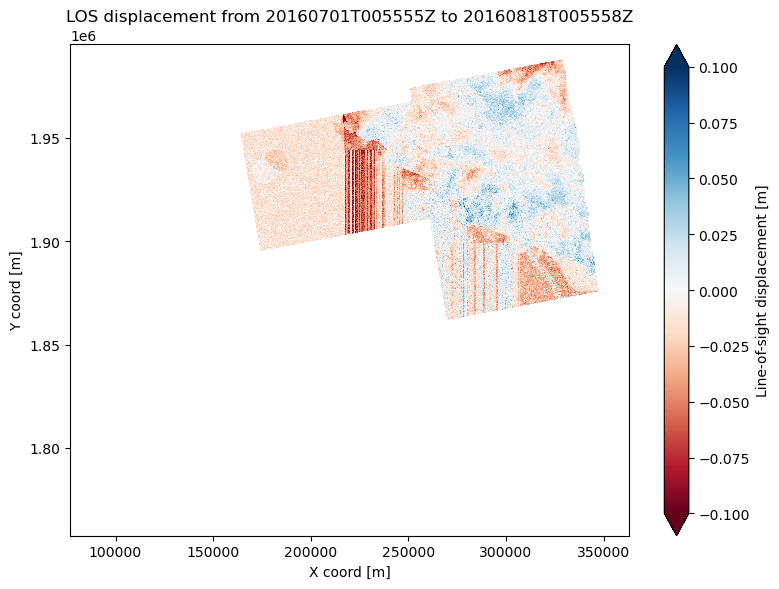

In [4]:
gname = results[0]["Granule"]["GranuleUR"]
t = re.search(r'_(\d{8}T\d{6}Z)_(\d{8}T\d{6}Z)', gname)
ts = f"{t.group(1)} to {t.group(2)}" if t else "Time unknown"

ds["displacement"].squeeze().plot(
    cmap="RdBu", vmin=-0.1, vmax=0.1, figsize=(8, 6),
    cbar_kwargs={"label": "Line-of-sight displacement [m]"}
)
plt.title(f"LOS displacement from {ts}")
plt.xlabel("X coord [m]"); plt.ylabel("Y coord [m]")
plt.tight_layout(); plt.show()


## Cloud Optimized Remote Access


This setup enables efficient streaming of large NetCDF files from NASA’s cloud using `earthaccess` and `fsspec`. By specifying `blockcache` and tuning HDF5 driver settings like `page_buf_size` and `rdcc_nbytes`, it optimizes chunked reads. The dataset is opened in-memory with `xr.open_dataset()` using `h5netcdf`, without without pre-downloading the entire file.


In [12]:
auth = earthaccess.login()

granules = earthaccess.search_data(
    count=1,
    short_name="OPERA_L3_DISP-S1_V1"
)
granule = granules[0]
url = granule.data_links(access="direct")[0]

credentials = auth.get_s3_credentials(
    endpoint=granule.get_s3_credentials_endpoint()
)

s3 = S3FileSystem(
    key=credentials['accessKeyId'],
    secret=credentials['secretAccessKey'],
    token=credentials['sessionToken']
)


In [13]:
io_params = {
    "fsspec_params": {
        "cache_type": "blockcache",
        "block_size": 8 * 1024 * 1024
    },
    "h5py_params": {
        "driver_kwds": {
            "page_buf_size": 16 * 1024 * 1024,
            "rdcc_nbytes": 4 * 1024 * 1024
        }
    }
}


In [14]:
ds = xr.open_dataset(
    s3.open(url, "rb", **io_params["fsspec_params"]),
    engine="h5netcdf",
    chunks="auto",  
    **io_params["h5py_params"]
)
ds

<xarray.Dataset> Size: 4GB
Dimensions:                         (y: 7915, x: 9548, time: 1)
Coordinates:
  * y                               (y) float64 63kB 1.995e+06 ... 1.758e+06
  * x                               (x) float64 76kB 7.682e+04 ... 3.632e+05
  * time                            (time) datetime64[ns] 8B 2016-08-18T00:55...
Data variables: (12/13)
    spatial_ref                     int64 8B ...
    reference_time                  (time) datetime64[ns] 8B dask.array<chunksize=(1,), meta=np.ndarray>
    displacement                    (y, x) float64 605MB dask.array<chunksize=(4096, 4096), meta=np.ndarray>
    short_wavelength_displacement   (y, x) float32 302MB dask.array<chunksize=(5632, 5632), meta=np.ndarray>
    recommended_mask                (y, x) float32 302MB dask.array<chunksize=(5632, 5632), meta=np.ndarray>
    connected_component_labels      (y, x) float32 302MB dask.array<chunksize=(5632, 5632), meta=np.ndarray>
    ...                              ...
    estimated_phase_quality         (y, x) float32 302MB dask.array<chunksize=(5632, 5632), meta=np.ndarray>
    persistent_scatterer_mask       (y, x) float32 302MB dask.array<chunksize=(5632, 5632), meta=np.ndarray>
    shp_counts                      (y, x) float32 302MB dask.array<chunksize=(5632, 5632), meta=np.ndarray>
    water_mask                      (y, x) float32 302MB dask.array<chunksize=(5632, 5632), meta=np.ndarray>
    phase_similarity                (y, x) float32 302MB dask.array<chunksize=(5632, 5632), meta=np.ndarray>
    timeseries_inversion_residuals  (y, x) float32 302MB dask.array<chunksize=(5632, 5632), meta=np.ndarray>
Attributes:
    Conventions:         CF-1.8
    contact:             opera-sds-ops@jpl.nasa.gov
    institution:         NASA JPL
    mission_name:        OPERA
    reference_document:  JPL D-108765
    title:               OPERA_L3_DISP-S1 Product

Each data variable (e.g., `displacement`, `temporal_coherence`) is internally chunked into blocks (e.g., (5632, 2283), (5632, 3916), or (4096, 3819)). This chunking enables partial reads via HTTP range requests using `fsspec`, allowing efficient, on-demand access without loading the full file into memory — ideal for cloud-based workflows.


## Cloud-Optimized Performance

This code uses `isel()` to select a small index-based window from the `displacement` variable. It applies `.compute()` to load only the required chunks with Dask. After filtering out NaNs, it plots a histogram of valid displacement values.

In [10]:
%time subset = ds['displacement'].isel(y=slice(230, 250), x=slice(8390, 8410)).compute()


CPU times: user 6.26 ms, sys: 3.61 ms, total: 9.87 ms
Wall time: 9.44 ms


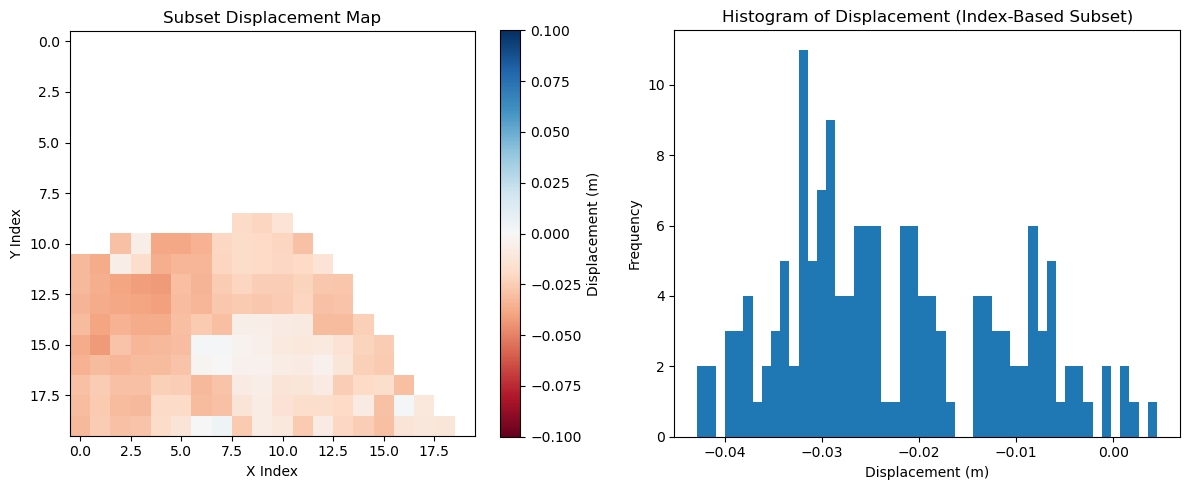

In [11]:
subset_vals = subset.values.flatten()
subset_vals = subset_vals[~np.isnan(subset_vals)]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Panel 1: Map of the subset
im = axes[0].imshow(subset.values, cmap="RdBu", vmin=-0.1, vmax=0.1)
axes[0].set_title("Subset Displacement Map")
axes[0].set_xlabel("X Index")
axes[0].set_ylabel("Y Index")
fig.colorbar(im, ax=axes[0], orientation='vertical', label="Displacement (m)")

# Panel 2: Histogram
axes[1].hist(subset_vals, bins=50)
axes[1].set_title("Histogram of Displacement (Index-Based Subset)")
axes[1].set_xlabel("Displacement (m)")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()
